In [1]:
# Task is to predict the fraudulent or not activity of a credit card issuer

In [2]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats.mstats import winsorize
from math import sqrt
from sklearn import metrics
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
import warnings

In [3]:
warnings.filterwarnings("ignore")

data = pd.read_csv('classification.csv')
data.rename(columns={ data.columns[0]: 'ID' }, inplace = True)
data = data.set_index('ID')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,V29
ID,,,,,,,,,,,,,,,,,,,,,
192992,1.746293,-1.475827,-1.176263,-0.806497,-0.455586,0.416916,-0.622420,0.118181,-0.186566,0.562834,...,0.376126,0.895472,0.108565,-0.933057,-0.358316,-0.084882,0.005640,-0.040196,0,17.115
145398,-1.933007,2.170092,-1.019098,0.994077,-0.222465,0.419611,-0.764879,-5.087273,0.029340,0.668526,...,4.916861,-0.245236,0.404277,-0.032567,-0.670983,0.197911,0.017548,0.429224,0,8.657
257703,-1.906249,2.259575,-3.456809,-1.555935,1.694769,2.968648,-1.070086,2.655979,-0.264319,-0.777369,...,-0.259470,-1.014989,0.364631,0.578321,-0.172432,0.188096,0.069366,-0.006161,0,1.170
78123,0.736022,-0.559744,-0.138791,1.524676,-0.355671,-0.340474,0.445512,-0.068794,0.262177,-0.112843,...,0.118406,-0.080323,-0.307862,0.071531,0.625638,-0.251570,-0.029669,0.048477,0,24.138
232047,-0.099218,0.718205,0.594968,-0.118072,0.068231,-1.703281,1.033911,-0.343339,-0.166651,-0.550745,...,0.467547,1.393917,-0.069643,0.957775,-0.614036,-0.217817,0.207589,0.228557,0,1.995


# Data Preparation

In [4]:
# Base statistics
print(data.describe(), '\n')

# Check for NaN values
print(data.isnull().sum(axis = 0))

                  V1             V2             V3             V4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.000885      -0.003707       0.002978      -0.005153   
std         1.933672       1.647123       1.501978       1.413148   
min       -40.470142     -60.464618     -48.325589      -5.416315   
25%        -0.920446      -0.602093      -0.884214      -0.850343   
50%         0.008738       0.064967       0.178816      -0.029706   
75%         1.312826       0.803071       1.024405       0.736172   
max         2.454930      16.697832       9.382558      16.875344   

                  V5             V6             V7             V8  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.003109      -0.001276       0.000434      -0.002431   
std         1.408358       1.346129       1.258873       1.201049   
min      -113.743307     -21.929312     -33.239328     -50.943369   
25%        -0.693751      -0.7683

In [5]:
#Checking for duplicates
print('\n', data.loc[data.duplicated()])


               V1        V2        V3        V4        V5        V6        V7  \
ID                                                                             
119009  1.244655 -0.091394  0.804806  0.075726 -1.154895 -1.364133 -0.272065   
262012  1.791803 -0.163626 -2.295408  1.026397  0.966210 -0.369313  0.806457   
34298   1.232505  0.224135 -0.108838  0.942922  0.674026  0.938628  0.001887   
76374   1.295257  0.400235 -1.832616  0.133846  2.551452  3.060135 -0.285335   
242541  2.040211 -0.146975 -2.955934 -0.578356  2.609358  3.142642 -0.416883   
...          ...       ...       ...       ...       ...       ...       ...   
166213  2.042124 -0.143815 -2.954824 -0.579160  2.610335  3.142285 -0.418197   
131197  1.151785 -0.017498  1.288855  1.341322 -0.963381 -0.194978 -0.545177   
134967  1.190770 -1.387425 -0.572325 -1.581099  0.798371  3.803154 -1.574477   
258076  1.790123 -0.676921 -1.407382 -0.100497  0.537655  1.070630 -0.264394   
276327  2.062347 -0.076676 -1.492637  

# Data Exploration

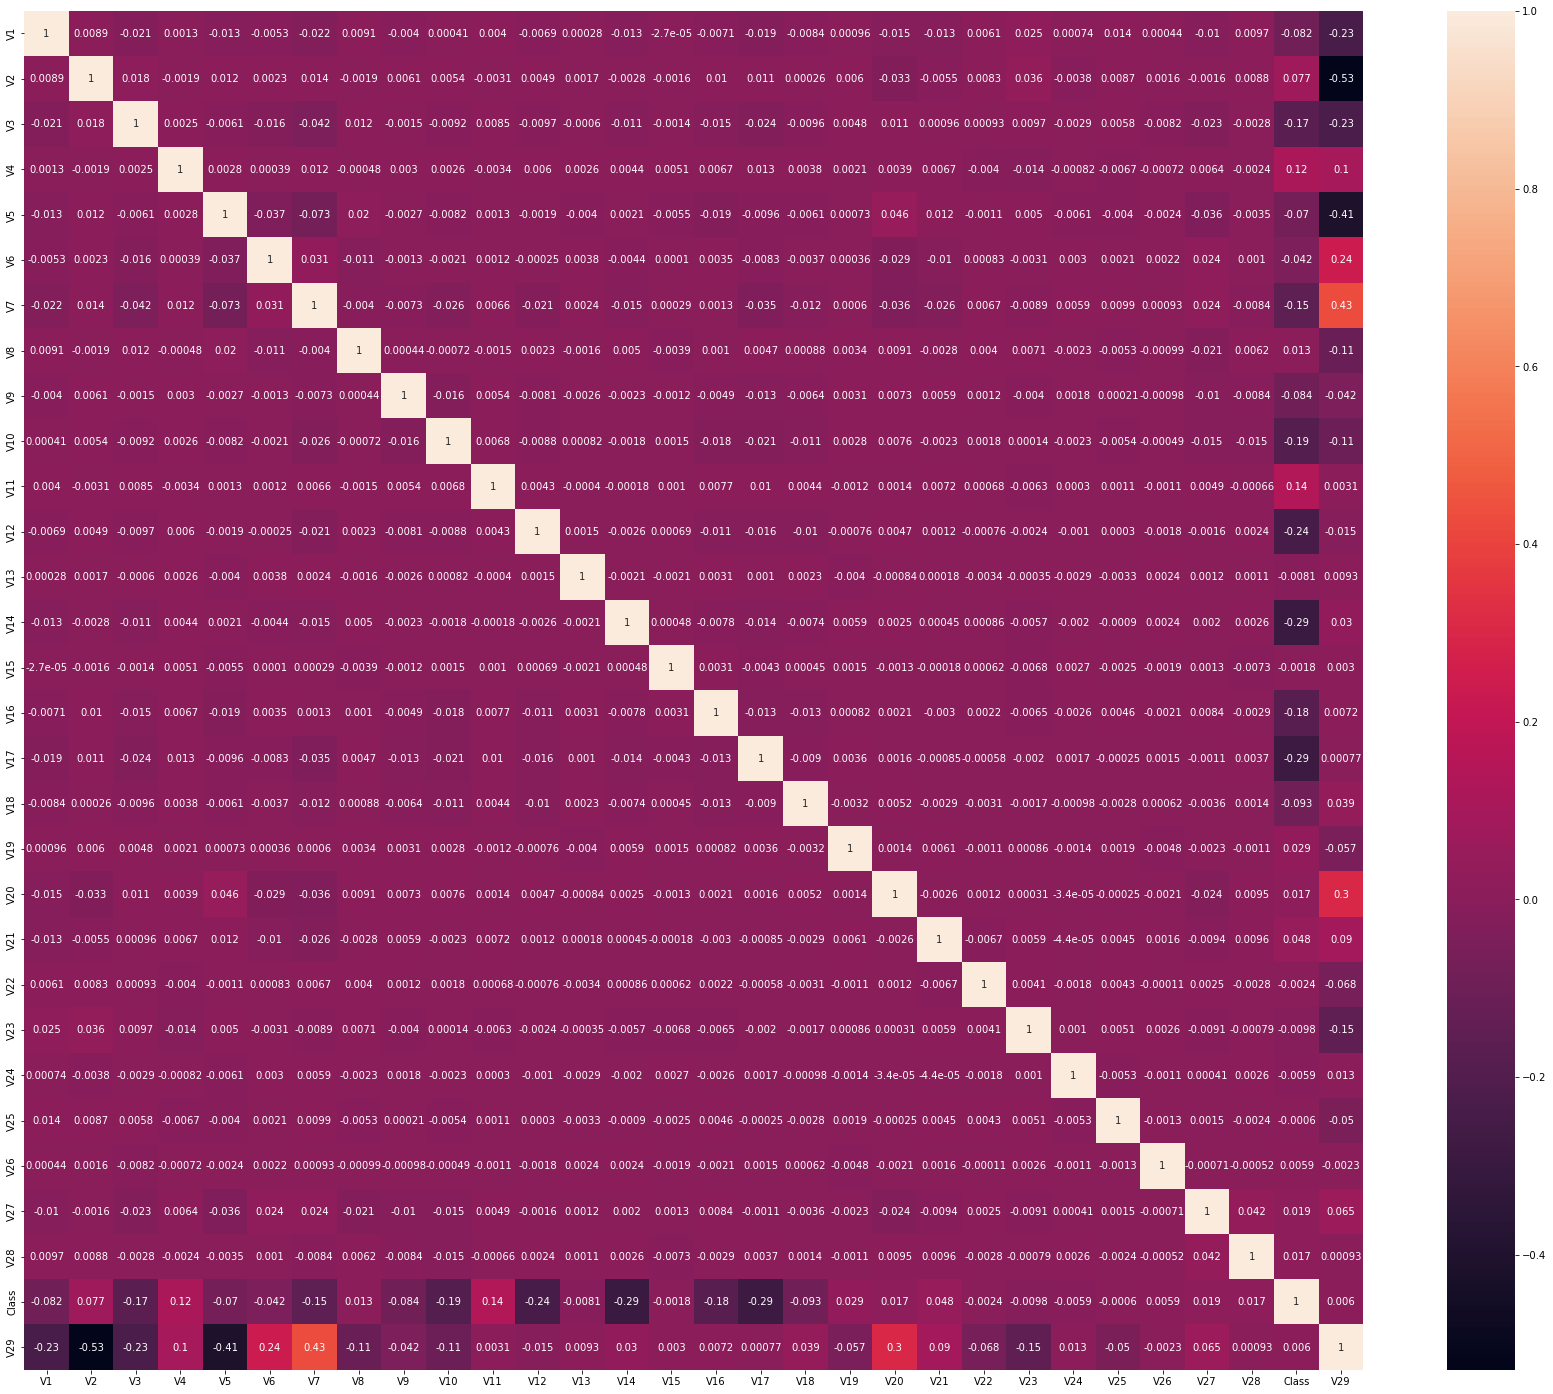

In [6]:
#Correlation plot
plt.figure(figsize = (30, 25))
sns.heatmap(data.corr(), annot = True)
plt.show()

In [7]:
# No significant corellation seem to appear in the data

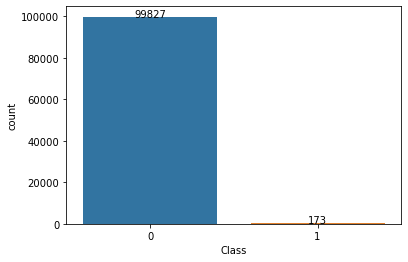

In [8]:
labels=data['Class'].value_counts().index
values=data['Class'].value_counts().values

ax = sns.countplot(x="Class", data=data)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")

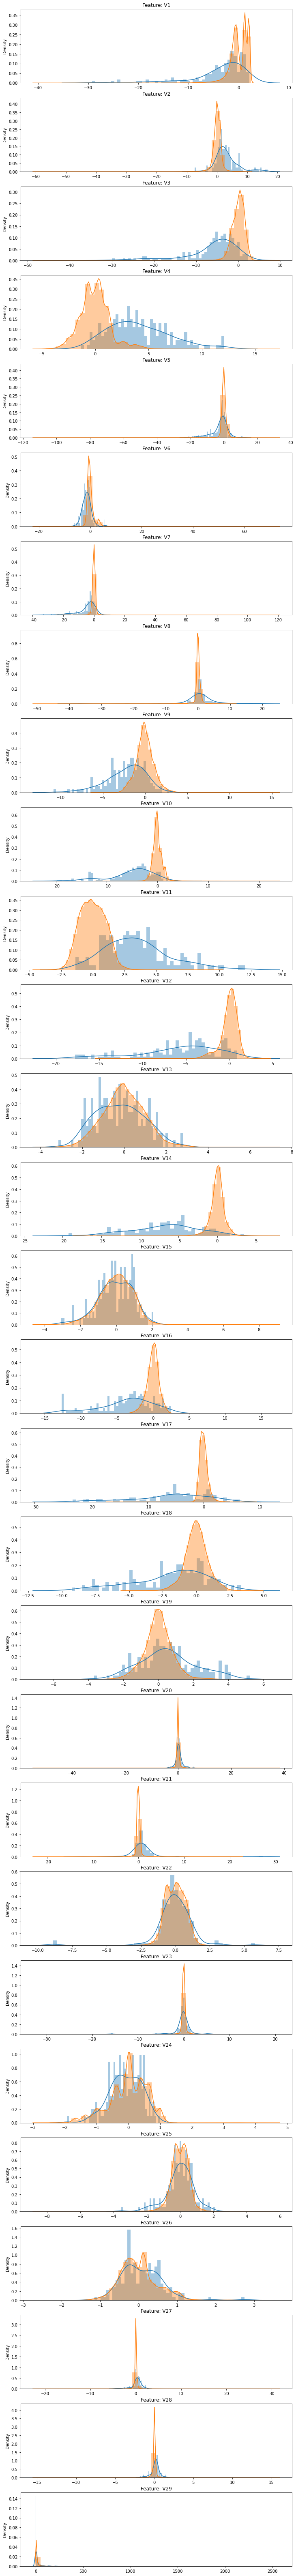

In [9]:
features = list(data.columns)
features = [e for e in features if e not in ('Class')]

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(data[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[feature][data.Class == 1], bins=50)
    sns.distplot(data[feature][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

In [10]:
# Attributes V13, V15, V20, V22, V23 show similar distribution meaning that the effect on prediction will probably be minimal

In [11]:
# Removal of above features
features = [e for e in features if e not in ('V13', 'V15', 'V20', 'V22', 'V23')]

# Winsorize data to replace outliers
for col in features:

    sorted_col = data[col].sort_values(ascending = True)
    q1, q3= np.percentile(sorted_col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    lower_limit = len(sorted_col.loc[lambda x: x<lower_bound])/len(sorted_col)
    upper_limit = len(sorted_col.loc[lambda x: x>upper_bound])/len(sorted_col)

    data[col] = winsorize(data[col], limits=[lower_limit, upper_limit])
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,V29
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.072812,0.048010,0.028505,-0.033205,-0.002040,-0.090689,0.008672,0.068448,-0.021499,-0.028936,...,-0.015121,-0.002329,-0.002472,-0.000304,0.002665,-0.004263,0.012422,0.011133,0.001730,5.224268
std,1.590551,1.123329,1.369657,1.308578,1.079935,1.003053,0.864232,0.485008,1.017574,0.825273,...,0.324783,0.727456,0.630689,0.593989,0.492051,0.467607,0.165574,0.124933,0.041557,6.239290
min,-4.269289,-2.709619,-3.747021,-3.228601,-2.653037,-2.520358,-2.241544,-1.010868,-2.505760,-2.020432,...,-0.854078,-9.499423,-32.828995,-1.542456,-1.318314,-1.179692,-0.314281,-0.251390,0.000000,0.000000
25%,-0.920446,-0.602093,-0.884214,-0.850343,-0.693751,-0.768357,-0.553170,-0.208844,-0.648607,-0.534156,...,-0.229348,-0.543823,-0.163770,-0.355694,-0.318015,-0.327781,-0.071095,-0.053099,0.000000,0.552000
50%,0.008738,0.064967,0.178816,-0.029706,-0.053770,-0.275355,0.040950,0.022258,-0.054630,-0.088608,...,-0.030414,0.007251,-0.012214,0.039884,0.016627,-0.053660,0.001211,0.011374,0.000000,2.214000
75%,1.312826,0.803071,1.024405,0.736172,0.612755,0.400304,0.572450,0.326067,0.589600,0.457323,...,0.187173,0.524716,0.146695,0.435526,0.348869,0.240239,0.091121,0.079126,0.000000,7.800000
max,2.454930,2.910316,3.868252,3.115750,2.572442,2.153324,2.260417,1.128393,2.446518,1.944408,...,0.811562,7.357255,20.803344,1.519264,1.349000,1.092246,0.334430,0.277460,1.000000,18.672000


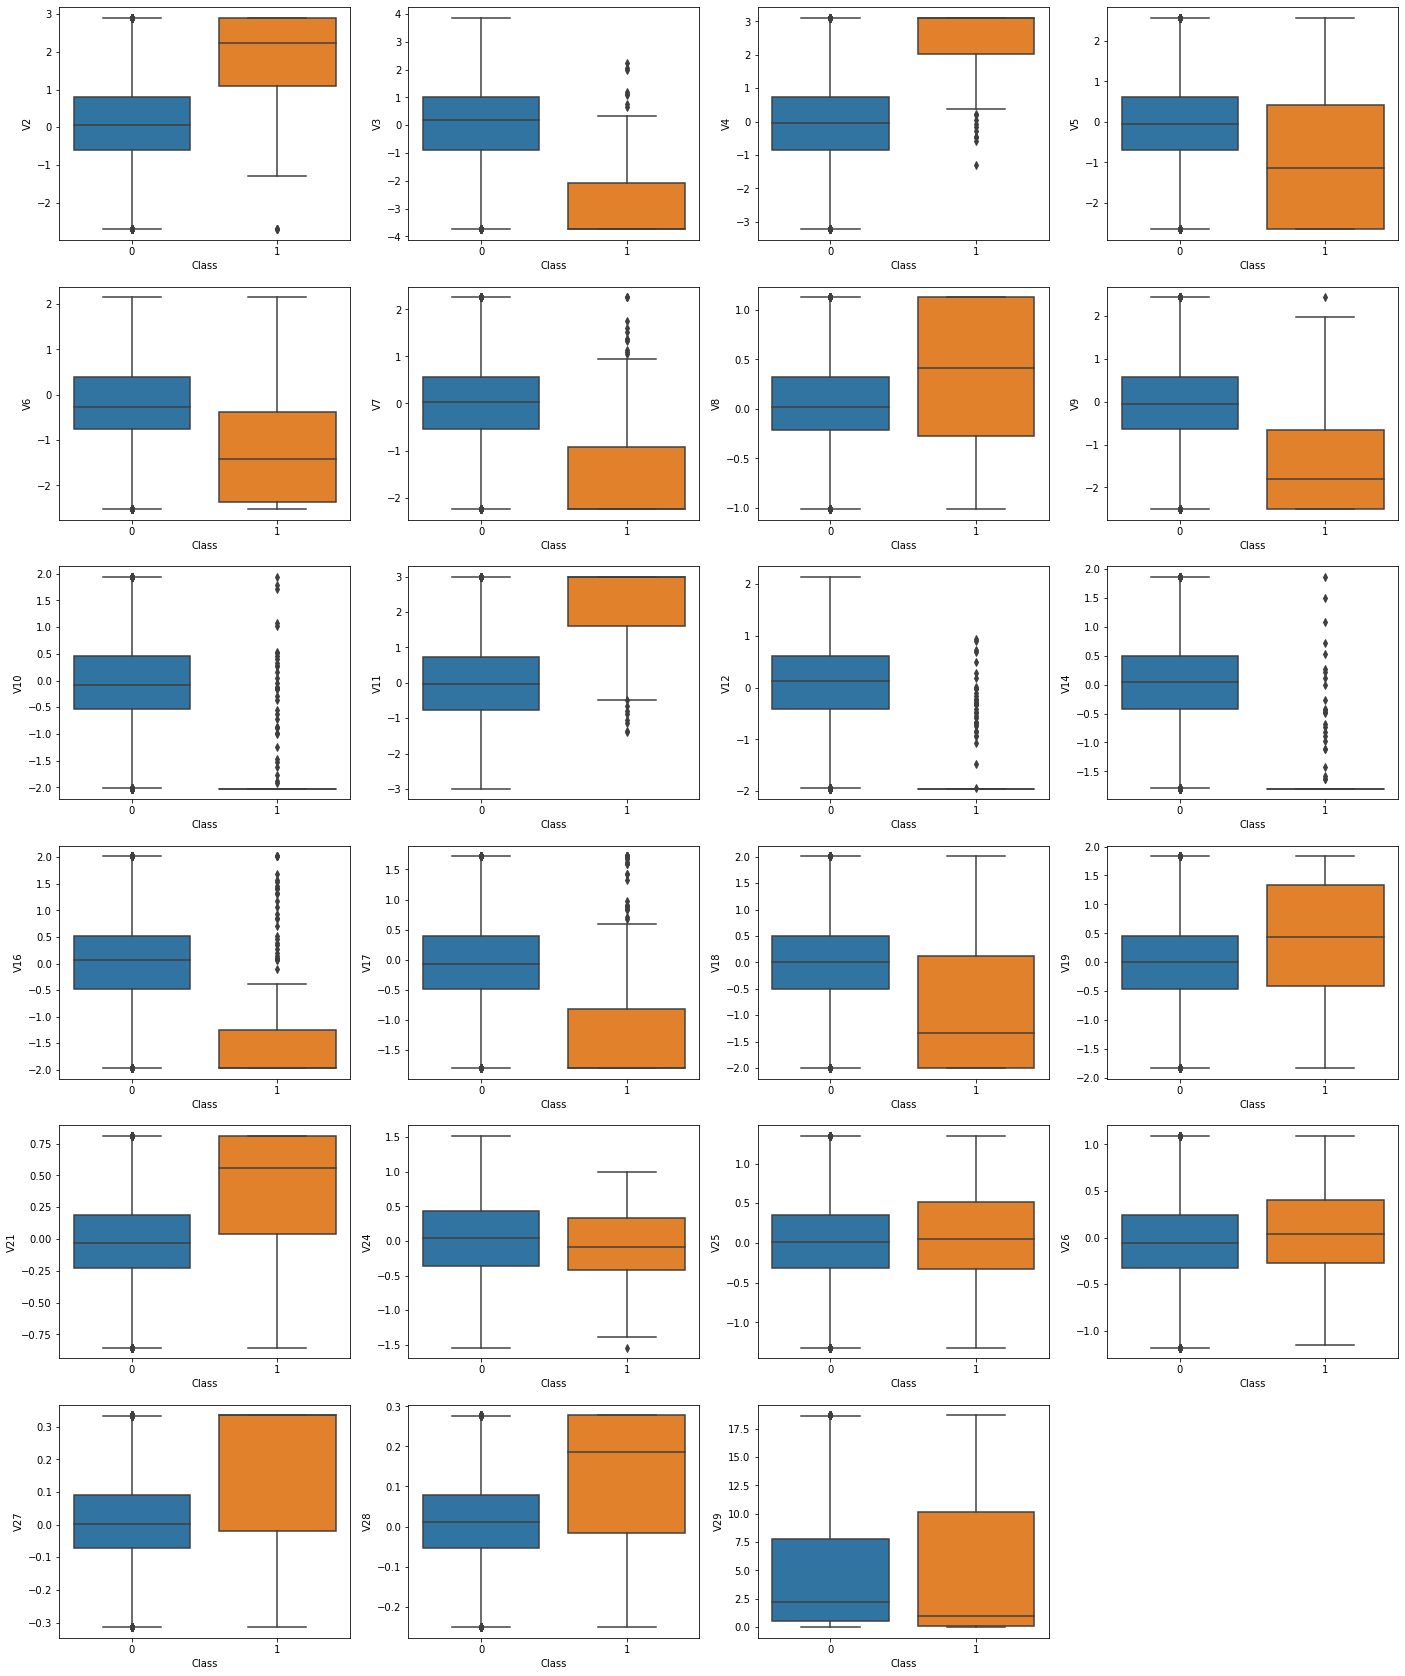

In [12]:
plt.figure(figsize=(24,30))

for col in range(1, 24, 1):
    
    plt.subplot(6,4,col)
    sns.boxplot(x="Class", y=features[col], data=data)

# Model Build

In [13]:
# X -> Predictors, y -> Target 
y = data['Class']
X = data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42) 

#Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]  

# Adjust weight for minority class
scale_pos_weight = data['Class'].value_counts()[0]/data['Class'].value_counts()[1]

clf  = xgb.XGBClassifier(max_depth = 5, subsample = 0.7, colsample_bytree = 0.7, 
                         n_estimators = 150, early_stopping = 10, learning_rate = 0.5,
                         colsample_bylevel=0.7, silent=True, n_jobs=4, eval_metric="error", 
                         random_state=42, verbosity = 0, scale_pos_weight = scale_pos_weight)


clf.fit(X_train_scaled, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test_scaled)

[0]	validation_0-error:0.02520	validation_1-error:0.02730
[1]	validation_0-error:0.01123	validation_1-error:0.01265
[2]	validation_0-error:0.00776	validation_1-error:0.00760
[3]	validation_0-error:0.00596	validation_1-error:0.00650
[4]	validation_0-error:0.00619	validation_1-error:0.00650
[5]	validation_0-error:0.00568	validation_1-error:0.00595
[6]	validation_0-error:0.00441	validation_1-error:0.00485
[7]	validation_0-error:0.00317	validation_1-error:0.00340
[8]	validation_0-error:0.00196	validation_1-error:0.00200
[9]	validation_0-error:0.00248	validation_1-error:0.00265
[10]	validation_0-error:0.00170	validation_1-error:0.00190
[11]	validation_0-error:0.00119	validation_1-error:0.00140
[12]	validation_0-error:0.00106	validation_1-error:0.00170
[13]	validation_0-error:0.00111	validation_1-error:0.00180
[14]	validation_0-error:0.00093	validation_1-error:0.00165
[15]	validation_0-error:0.00066	validation_1-error:0.00140
[16]	validation_0-error:0.00064	validation_1-error:0.00115
[17]	va

[139]	validation_0-error:0.00000	validation_1-error:0.00055
[140]	validation_0-error:0.00000	validation_1-error:0.00055
[141]	validation_0-error:0.00000	validation_1-error:0.00055
[142]	validation_0-error:0.00000	validation_1-error:0.00055
[143]	validation_0-error:0.00000	validation_1-error:0.00055
[144]	validation_0-error:0.00000	validation_1-error:0.00055
[145]	validation_0-error:0.00000	validation_1-error:0.00055
[146]	validation_0-error:0.00000	validation_1-error:0.00055
[147]	validation_0-error:0.00000	validation_1-error:0.00055
[148]	validation_0-error:0.00000	validation_1-error:0.00050
[149]	validation_0-error:0.00000	validation_1-error:0.00055


In [15]:
print('\n\nOverall Metrics\n\n', classification_report(y_test, y_pred))



Overall Metrics

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19969
           1       0.88      0.74      0.81        31

    accuracy                           1.00     20000
   macro avg       0.94      0.87      0.90     20000
weighted avg       1.00      1.00      1.00     20000



# Evaluation Measures

<Figure size 2160x4320 with 0 Axes>

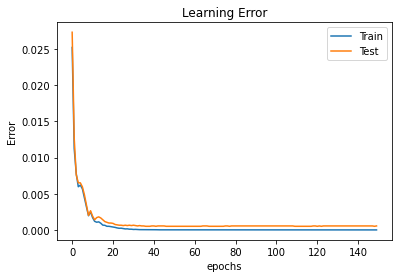

In [16]:
# Plot of training error to make sure we are not overfitting
results = clf.evals_result()
plt.figure(figsize=(30,60))
   
# retrieve performance metrics
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.xlabel('epochs')
plt.ylabel('Error')
plt.title('Learning Error')
plt.show()

Text(0.5, 0, 'False Positive Rate')

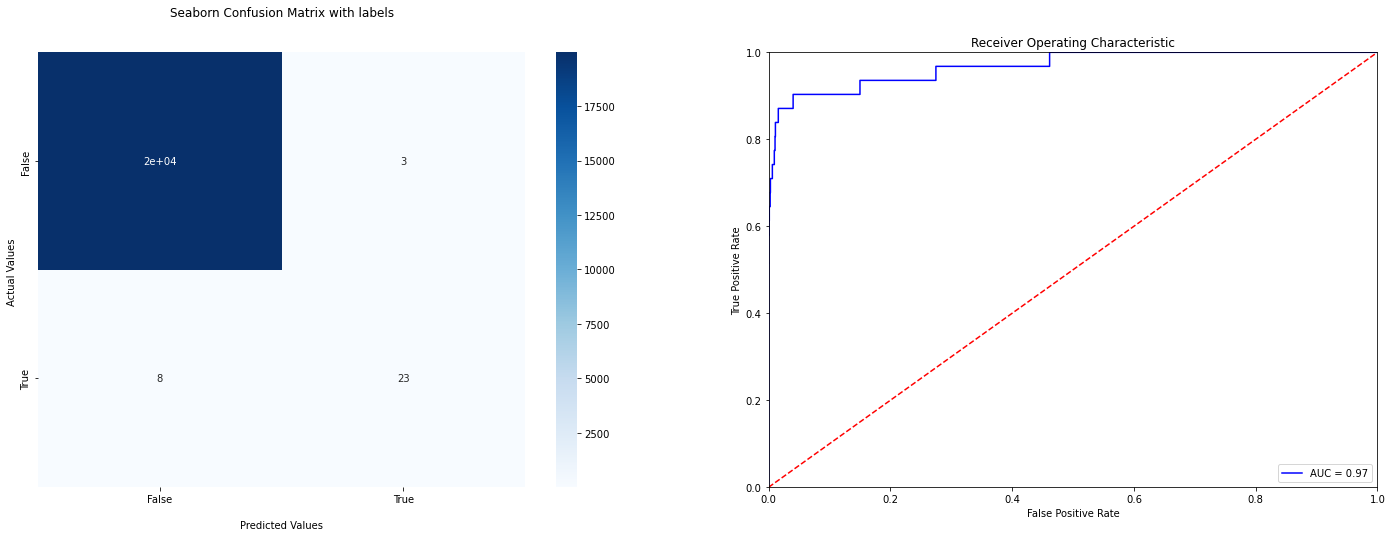

In [17]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(24,8))

# Plot confusion Matrix although it is not the best measure when handling imbalanced dataset
plt.subplot(1,2,1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Plot AUC curve
plt.subplot(1,2,2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

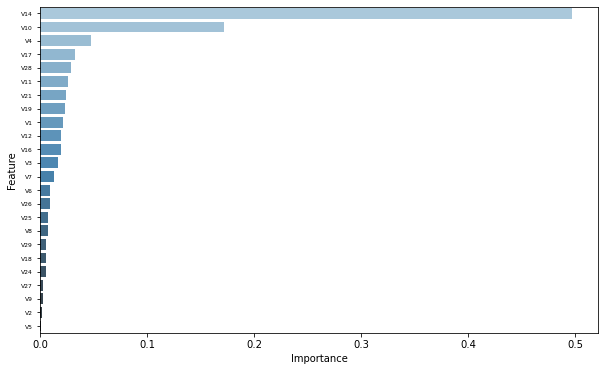

In [18]:
# Plot of most important features
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

feat_imp_plot = importances.iloc[:][:]
plt.figure(figsize = (10,6))
ax = sns.barplot(x=feat_imp_plot['Importance'], y=feat_imp_plot.index, data=feat_imp_plot, palette="Blues_d")
_, labels = plt.yticks()
# set the label size
ax.set_yticklabels(labels, size = 6)
plt.show()

# Next Steps

In [19]:
# Hyparameter tuning
# Check resampling methods e.g. SMOTE